In [0]:
# mount the drive for getting data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [2]:
# check the availability of the GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import csv

import warnings
warnings.filterwarnings('ignore')

import gensim
import re
import seaborn as sns
from collections import Counter

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, WordPunctTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

from sklearn.decomposition import PCA
import pickle

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Wrangling

In [61]:
# import the critical findings dataset which is in csv format
df_critical = pd.read_csv('/content/drive/My Drive/Critical_Findings/critical-findings-sample-data-20180601-20180901.csv')
df_critical.replace(['Complete Critical Finding', 'Complete Physician Decline'],['complete_critical_findings','complete_physician_decline'],inplace=True)
df_critical.head()

,Modality,Critical_Finding,Category,Data
0,CT,complete_critical_findings,Significant Vascular Pathology,STUDY: CT CHEST WITH CONTRAST<br /><br />REA...
1,CT,complete_critical_findings,Significant Vascular Pathology,STUDY: CT CHEST WITH CONTRAST<br /><br />REA...
2,CT,complete_critical_findings,Significant Vascular Pathology,STUDY: CT CHEST WITH CONTRAST<br /><br />REA...
3,CT,complete_critical_findings,Acute Vascular Event,HISTORY: left sided weakness<br /><br />TECHNI...
4,CT,complete_critical_findings,Acute Vascular Event,HISTORY: left sided weakness<br /><br />TECHNI...


In [62]:
# import the non-critical dataset which is in csv format
df_noncritical = pd.read_csv('/content/drive/My Drive/Critical_Findings/non-critical-findings-sample-data-20180601-20180901.csv')
df_noncritical.Critical_Finding.replace('None','no_critical_finding',inplace=True)
df_noncritical.Category.replace(np.nan,'no_category',inplace=True)
df_noncritical.head()

,Modality,Critical_Finding,Category,Data
0,CR,no_critical_finding,no_category,STUDY: X-RAY - LEFT HAND<br /><br />REASON F...
1,US,no_critical_finding,no_category,STUDY: VENOUS DOPPLER ULTRASOUND -LEFT UPPER...
2,CR,no_critical_finding,no_category,XR Chest 1 View<br /><br />INDICATION: for com...
3,CR,no_critical_finding,no_category,STUDY: X-RAY CHEST<br /><br />REASON FOR EXA...
4,US,no_critical_finding,no_category,STUDY: VENOUS DOPPLER ULTRASOUND - LEFT LOWE...


### Merge both datasets

In [63]:
# append both datasets into one dataframe 
df = df_critical.append(df_noncritical)

# free memory by deleting partial datasets
del df_noncritical
del df_critical
df.head()

,Modality,Critical_Finding,Category,Data
0,CT,complete_critical_findings,Significant Vascular Pathology,STUDY: CT CHEST WITH CONTRAST<br /><br />REA...
1,CT,complete_critical_findings,Significant Vascular Pathology,STUDY: CT CHEST WITH CONTRAST<br /><br />REA...
2,CT,complete_critical_findings,Significant Vascular Pathology,STUDY: CT CHEST WITH CONTRAST<br /><br />REA...
3,CT,complete_critical_findings,Acute Vascular Event,HISTORY: left sided weakness<br /><br />TECHNI...
4,CT,complete_critical_findings,Acute Vascular Event,HISTORY: left sided weakness<br /><br />TECHNI...


In [0]:
df.dtypes

### Data Cleaning

**Steps in Text Preprocessing**
1. **tags removal** : \&gt;   \&lt;    \&quot;   \<br />
2. **Lower Case** 
3. **Deontraction**
4. **Replacing words not in Word Embeddings**
5. **Punctuations and Numbers Removal**:
6. **Stopwords Removal**
7. **Removal of Smaller length words (len <= 2)**
8. **Tokenization**
9. **Lematization**


In [0]:
# import stop words for english
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [0]:
# tokenizer
tok = WordPunctTokenizer()

# replacement dictionary
replace_dict ={'c-collar':'cervical collar',
               'c-section':'caesarean section',
               'c-spine':'cervical spine',
               'chest-shortness':'chest pain and shortness of breath',
               'cul-de-sac':'dead end',
               'csf':'cerebrospinal fluid',
               'd-dimer':'ddimer',
               'x-ray':'xray',
               'x-rays':'xray',
               'ct':'computed tomography',               
               'barchie':'',
               'kamholtz':'',
               'neuroforamina':'',
               'bibasilar':'',
               'breckwoldt': '',
               'costophrenic': 'places where the diaphragm meets the ribs',
               'ctdivol': 'volume computed tomography dose index',
               'hyperdensity': 'high hemoglobin content of retracted clot or blood',
               'mgycm': 'absorbed radiation per kilogram per centimeter',
               'neuroforamina': 'compression of a spinal nerve',
               'nonobstructing': 'non obstructing',
               'periappendiceal': 'near the appendix'
              }

# tags found in data
tags = ['&gt;','&lt;','&quot;','<br />']

In [0]:
# function for text-preprocessing 
def text_preprocessor(text):
  
  #tag removal
  for tag in tags:
    text = text.replace(tag, ' ')
  
  # decontract the contractions
  def decontract(phrase):
    #phrase = re.sub(r"n\'t", " not", phrase)
    #phrase = re.sub(r"\'re", " are", phrase)
    #phrase = re.sub(r"\'s", " is", phrase)
    #phrase = re.sub(r"\'d", " would", phrase)
    #phrase = re.sub(r"\'ll", " will", phrase)
    #phrase = re.sub(r"\'t", " not", phrase)
    #phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
  decontracted = decontract(text)

  # lower case
  lower_case = decontracted.lower()

  # replacements
  for before, after in replace_dict.items():
    lower_case = ' '.join([after if before==word else word for word in lower_case.split() ])
  
  # punctuations and numeric removal
  letters_only = re.sub("[^a-zA-Z]", " ", lower_case)
  
  # remove words with 2 or fewer characters
  removed = re.sub(r'\b\w{1,2}\b', '', letters_only)
  
  # tokenize
  words = tok.tokenize(removed)

  # stop words removal
  #stop_word_removed = [word for word in words if word not in stopword_list]
  
  # lemmatize words using WordNet
  lmtzr = WordNetLemmatizer()
  lemmatized_list = [lmtzr.lemmatize(word) for word in words]
  lemmatized_sentence = ' '.join(lemmatized_list)
  
  return lemmatized_sentence

In [0]:
# Cleaning the text on entire df
df.Data = df.Data.apply(text_preprocessor)

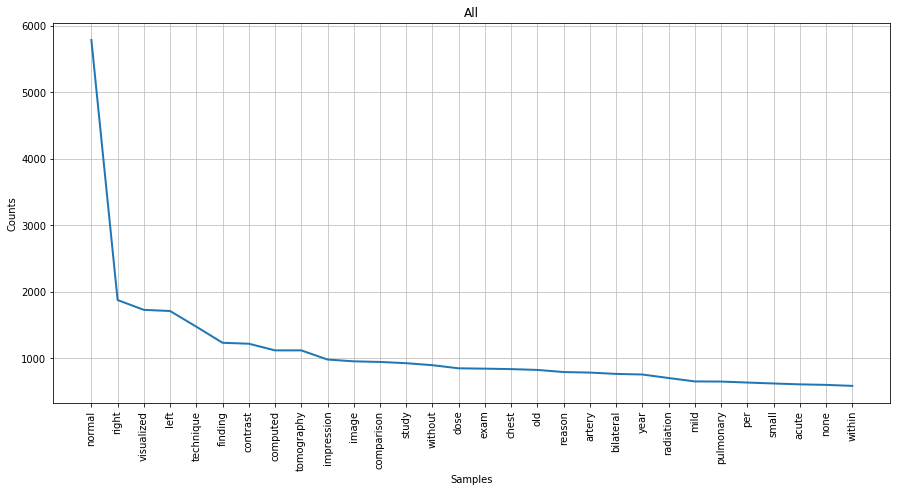

<Figure size 432x288 with 0 Axes>

In [12]:
# Frequency Distribution of words appearing in whole data
plt.figure(figsize=(15, 7))
all_words = Counter()
for text in df.Data:
  all_words += Counter(text.split())
fd = nltk.FreqDist(all_words)
fd.plot(30,cumulative=False, title = 'All')
plt.savefig('./FreqDist_all.png')

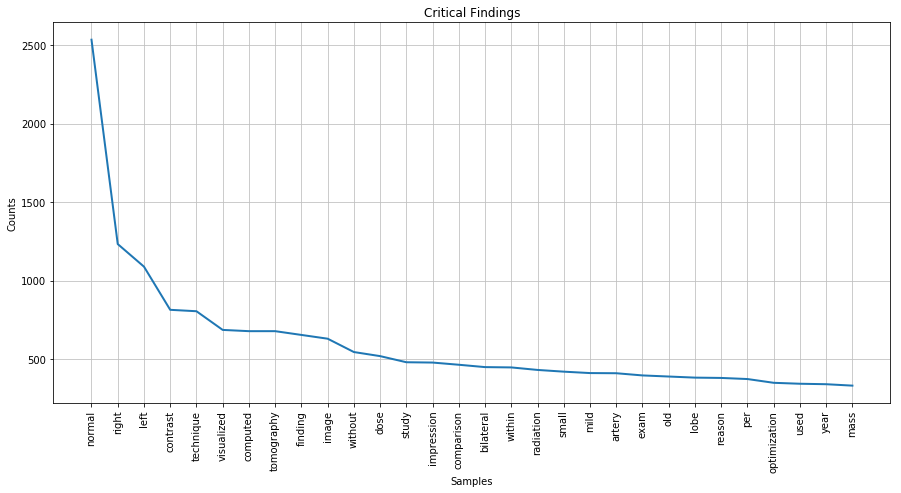

In [13]:
# Frequency Distribution of words appearing in critical findings dataset
plt.figure(figsize=(15, 7))
critical_words = Counter()
for text in df.Data[df.Critical_Finding == 'complete_critical_findings']:
  critical_words += Counter(text.split())
fd = nltk.FreqDist(critical_words)
fd.plot(30,cumulative=False, title = 'Critical Findings')
del critical_words

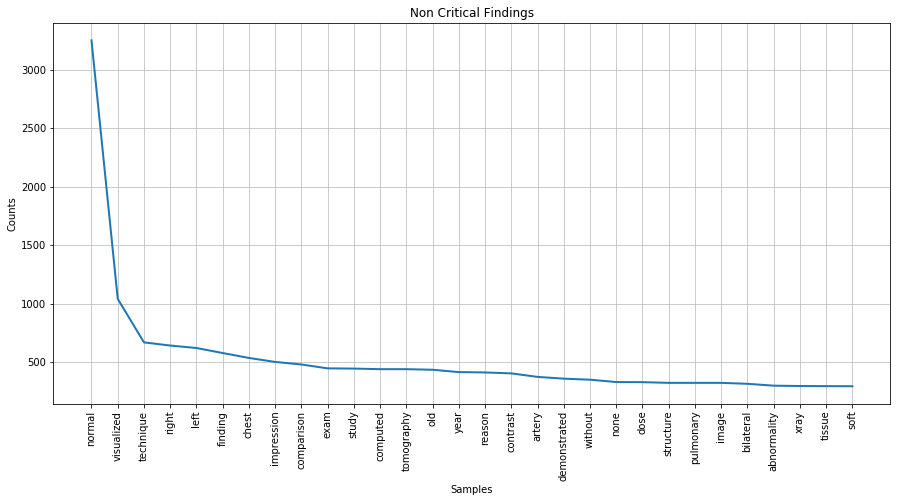

In [14]:
# Frequency Distribution of words appearing in non-critical findings
plt.figure(figsize=(15, 7))
non_critical_words = Counter()
for text in df.Data[df.Critical_Finding != 'complete_critical_findings']:
  non_critical_words += Counter(text.split())
fd = nltk.FreqDist(non_critical_words)
ax=fd.plot(30,cumulative=False,title = 'Non Critical Findings')
del non_critical_words

In [0]:
# importing Glove Embeddings into a dictionary

'''
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip glove*

glove_embeddings = {}
f = open('glove.42B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = coefs
f.close()
'''

# Pickle the dictionary for future usage

'''
with open('/content/drive/My Drive/Critical_Findings/glove_embeddings.p', 'wb') as fp:
  pickle.dump(glove_embeddings, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''

# Import the pickled glove embeddings

with open('/content/drive/My Drive/Critical_Findings/glove_embeddings.p', 'rb') as fp:
  glove_embeddings = pickle.load(fp)

In [0]:
# Check the words not in glove embeddings - NOT required as the embeddings for words not in glove are set to zero

'''
odd_words = set(all_words.keys()) - set(glove_embeddings.keys())
odd_words_freq = Counter()
for word in odd_words:
  odd_words_freq[word] = all_words[word]
'''

## Embeddings

### Bag Of Words (BOW)
- Bag of Words (BOW) is an algorithm that counts how many times a word appears in a document.
- The vector shape is determined in the corpus vocabulary size

In [0]:
# Convert the text data into vectors using Bag-Of-Words Vectorizer and pickle it for future usage

'''
bow_transformer = CountVectorizer()
text_bow = bow_transformer.fit_transform(df.Data)

print('Shape of Sparse Matrix: ', text_bow.shape)

bow_matrix = text_bow.todense()
df_bow = pd.DataFrame(bow_matrix, columns=list(bow_transformer.get_feature_names()))
df_bow.head()

with open('/content/drive/My Drive/Critical_Findings/df_bow.p', 'wb') as fp:
    pickle.dump(df_bow, fp, protocol=pickle.HIGHEST_PROTOCOL)    
'''
   
# load the pickled dataset for BOW
with open('/content/drive/My Drive/Critical_Findings/df_bow.p', 'rb') as fp:
  df_bow = pickle.load(fp)

### Term Frequency — Inverse Document Frequency
- TF-IDF are similar to BOW embeddings with a small twist
1. A document is transformed by counting the number of times each word in the vocabulary appears in the document, known as Term-Frequency
2. The weight of each word is normalized by the number of times it appears in the corpus, known as Inverse-Document-Frequency

- N-grams are simply all combinations of adjacent words or letters of length *n* that are present in the corpus.
- We have used Tf-Idf with 1, 1+2 and 1+2+3 gram modelling.

In [0]:
# Convert the text data into vectors using Tfidf-Vectorizer w/ 1-gram and pickle it for future usage

'''
tfidf_vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,1), sublinear_tf=True)
text_tfidf = tfidf_vectorizer.fit_transform(df.Data)

print(text_tfidf.shape)

tfidf_matrix = text_tfidf.todense()
df_tfidf_1gram = pd.DataFrame(tfidf_matrix, columns=list(tfidf_vectorizer.get_feature_names()))
df_tfidf_1gram.head()

with open('/content/drive/My Drive/Critical_Findings/df_tfidf_1gram.p', 'wb') as fp:
  pickle.dump(df_tfidf_1gram, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''

# load the pickled dataset for Tfidf-1gram
with open('/content/drive/My Drive/Critical_Findings/df_tfidf_1gram.p', 'rb') as fp:
  df_tfidf_1gram = pickle.load(fp)

In [24]:
# Convert the text data into vectors using Tfidf-Vectorizer w/ 1+2-gram and pickle it for future usage

'''
tfidf_vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,2), sublinear_tf=True)
text_tfidf = tfidf_vectorizer.fit_transform(df.Data)

print(text_tfidf.shape)

tfidf_matrix = text_tfidf.todense()
df_tfidf_2gram = pd.DataFrame(tfidf_matrix, columns=list(tfidf_vectorizer.get_feature_names()))
df_tfidf_2gram.head()

with open('/content/drive/My Drive/Critical_Findings/df_tfidf_2gram.p', 'wb') as fp:
   pickle.dump(df_tfidf_2gram, fp, protocol=pickle.HIGHEST_PROTOCOL)

'''

# load the pickled dataset for Tfidf-2gram
with open('/content/drive/My Drive/Critical_Findings/df_tfidf_2gram.p', 'rb') as fp:
  df_tfidf_2gram = pickle.load(fp)
df_tfidf_2gram.head()

,abcess,abcess abcess,abcess lower,abd,abd bleeding,abd distention,abd pain,abd painexam,abd paintech,abdm,abdm pain,abdomen,abdomen along,abdomen appendix,abdomen ascites,abdomen cecal,abdomen comparison,abdomen contrast,abdomen coursing,abdomen demonstrate,abdomen demonstrates,abdomen evolving,abdomen finding,abdomen grossly,abdomen image,abdomen impression,abdomen ivc,abdomen large,abdomen limited,abdomen loop,abdomen may,abdomen midline,abdomen moderate,abdomen obtained,abdomen pain,abdomen pelvic,abdomen pelvis,abdomen persistent,abdomen reason,abdomen reveal,...,xray lumbar,xray may,xray orbit,xray recommended,xray report,xray right,xray soft,xray thoracic,xray unilateral,xxx,xxx finding,year,year ago,year hepatic,year nausea,year old,year overall,year radiation,yestech,yestech note,yesterday,yesterday chest,yesterday pain,yesterday technique,yet,yet apparent,yet multiple,yolk,yolk sac,young,young song,yr,yr numbness,yr trauma,zone,zone bilaterally,zone lung,zone probably,zygomatic,zygomatic arch
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025965,0.0,0.0,0.0,0.025965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025965,0.0,0.0,0.0,0.025965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025965,0.0,0.0,0.0,0.025965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Convert the text data into vectors using Tfidf-Vectorizer w/ 1+2+3-gram and pickle it for future usage

'''
tfidf_vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(1,3), sublinear_tf=True)
text_tfidf = tfidf_vectorizer.fit_transform(df.Data)

print(text_tfidf.shape)

tfidf_matrix = text_tfidf.todense()
df_tfidf_3gram = pd.DataFrame(tfidf_matrix, columns=list(tfidf_vectorizer.get_feature_names()))
df_tfidf_3gram.head()

with open('/content/drive/My Drive/Critical_Findings/df_tfidf_3gram.p', 'wb') as fp:
    pickle.dump(df_tfidf_3gram, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''


# load the pickled dataset for Tfidf-3gram

with open('/content/drive/My Drive/Critical_Findings/df_tfidf_3gram.p', 'rb') as fp:
  df_tfidf_3gram = pickle.load(fp)
  
df_tfidf_3gram.head()

,abcess,abcess abcess,abcess abcess lower,abcess lower,abcess lower occipital,abd,abd bleeding,abd bleeding hernia,abd distention,abd distention prostate,abd distention vomiting,abd pain,abd pain constipation,abd pain hour,abd pain nausea,abd pain technique,abd pain vaginal,abd painexam,abd painexam indication,abd paintech,abd paintech note,abdm,abdm pain,abdm pain radiation,abdomen,abdomen along,abdomen along left,abdomen appendix,abdomen appendix not,abdomen ascites,abdomen ascites free,abdomen ascites possible,abdomen cecal,abdomen cecal level,abdomen comparison,abdomen comparison chest,abdomen comparison none,abdomen contrast,abdomen contrast recommended,abdomen coursing,...,yestech note,yestech note single,yestech note technique,yesterday,yesterday chest,yesterday chest pain,yesterday pain,yesterday pain severe,yesterday technique,yesterday technique noncontrast,yet,yet apparent,yet apparent mri,yet multiple,yet multiple colonic,yolk,yolk sac,yolk sac measure,yolk sac placenta,yolk sac yolk,young,young song,young song previous,young song reported,yr,yr numbness,yr numbness tingling,yr trauma,yr trauma surgery,zone,zone bilaterally,zone bilaterally hyperinflation,zone lung,zone lung left,zone probably,zone probably chronic,zygomatic,zygomatic arch,zygomatic arch adjacent,zygomatic arch pterygoid
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.027576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Google's Word2vec

- Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network.
- It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

In [0]:
# Download the Google's pre-trained Word2Vec embeddings and load it into a dictionary using gensim and pickle it

'''
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
!gunzip GoogleNews-vectors-negative300.bin.gz

word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

with open('/content/drive/My Drive/Critical_Findings/word2vec.p', 'wb') as fp:
  pickle.dump(word2vec, fp, protocol=pickle.HIGHEST_PROTOCOL)

'''

# load the pickled Word2Vec Embeddings

with open('/content/drive/My Drive/Critical_Findings/word2vec.p', 'rb') as fp:
  word2vec = pickle.load(fp)

In [0]:
# Convert the text data to vectors using Word2Vec embeddings
# All the vectors in a sentence are averaged for getting final embedding

'''
temp_2d_array = []
for sent in df.Data:
  sent_array = np.array([0.0]*300)
  word_count = 0
  for word in sent.split():
    try:
      sent_array = np.add(sent_array, word2vec[word])
      word_count += 1      
    except:
      pass
  temp_2d_array.append(sent_array/word_count)

df_w2v = pd.DataFrame(np.array(temp_2d_array))
del temp_2d_array

with open('/content/drive/My Drive/Critical_Findings/df_w2v.p', 'wb') as fp:
    pickle.dump(df_w2v, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''

# load the pickled dataset for Word2Vec
    
with open('/content/drive/My Drive/Critical_Findings/df_w2v.p', 'rb') as fp:
  df_w2v = pickle.load(fp)

In [29]:
df_w2v.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.051892,0.079481,0.023791,0.066895,-0.129703,0.053476,0.026391,-0.088863,0.015910,0.049806,-0.126963,-0.117266,0.005146,0.111978,-0.028848,0.064272,0.005472,0.151603,-0.069827,-0.052283,-0.027614,-0.021712,-0.060619,0.024698,-0.037603,-0.091223,-0.149745,0.091000,-0.027107,-0.039742,0.005270,-0.085500,-0.025744,-0.011203,-0.104644,-0.006806,0.011202,0.045499,0.013633,0.006442,...,0.019221,-0.055745,0.033194,-0.011225,0.027139,0.136786,0.037517,-0.097895,-0.042907,-0.113836,-0.042192,0.130143,-0.020891,-0.056133,0.145658,-0.061429,-0.063680,-0.037770,-0.004610,0.016601,-0.007464,0.107089,-0.013822,-0.085645,0.024994,-0.012344,0.004280,-0.021158,0.011235,0.014337,-0.069504,-0.007910,-0.033900,0.034896,-0.031056,-0.011040,-0.042183,-0.010379,0.096855,0.058442
1,-0.051892,0.079481,0.023791,0.066895,-0.129703,0.053476,0.026391,-0.088863,0.015910,0.049806,-0.126963,-0.117266,0.005146,0.111978,-0.028848,0.064272,0.005472,0.151603,-0.069827,-0.052283,-0.027614,-0.021712,-0.060619,0.024698,-0.037603,-0.091223,-0.149745,0.091000,-0.027107,-0.039742,0.005270,-0.085500,-0.025744,-0.011203,-0.104644,-0.006806,0.011202,0.045499,0.013633,0.006442,...,0.019221,-0.055745,0.033194,-0.011225,0.027139,0.136786,0.037517,-0.097895,-0.042907,-0.113836,-0.042192,0.130143,-0.020891,-0.056133,0.145658,-0.061429,-0.063680,-0.037770,-0.004610,0.016601,-0.007464,0.107089,-0.013822,-0.085645,0.024994,-0.012344,0.004280,-0.021158,0.011235,0.014337,-0.069504,-0.007910,-0.033900,0.034896,-0.031056,-0.011040,-0.042183,-0.010379,0.096855,0.058442
2,-0.051892,0.079481,0.023791,0.066895,-0.129703,0.053476,0.026391,-0.088863,0.015910,0.049806,-0.126963,-0.117266,0.005146,0.111978,-0.028848,0.064272,0.005472,0.151603,-0.069827,-0.052283,-0.027614,-0.021712,-0.060619,0.024698,-0.037603,-0.091223,-0.149745,0.091000,-0.027107,-0.039742,0.005270,-0.085500,-0.025744,-0.011203,-0.104644,-0.006806,0.011202,0.045499,0.013633,0.006442,...,0.019221,-0.055745,0.033194,-0.011225,0.027139,0.136786,0.037517,-0.097895,-0.042907,-0.113836,-0.042192,0.130143,-0.020891,-0.056133,0.145658,-0.061429,-0.063680,-0.037770,-0.004610,0.016601,-0.007464,0.107089,-0.013822,-0.085645,0.024994,-0.012344,0.004280,-0.021158,0.011235,0.014337,-0.069504,-0.007910,-0.033900,0.034896,-0.031056,-0.011040,-0.042183,-0.010379,0.096855,0.058442
3,-0.004518,0.075347,0.032510,0.021926,-0.103733,0.021419,0.000290,-0.116759,0.054312,0.020876,-0.101131,-0.099360,-0.001131,0.055690,-0.005070,0.036595,-0.025638,0.166561,-0.013271,-0.033707,0.024487,0.003921,-0.019556,0.065610,-0.053835,-0.060046,-0.136382,0.004636,-0.026344,-0.018620,-0.021522,-0.041242,-0.028922,-0.014994,-0.091524,-0.029675,0.020687,0.027168,0.039862,0.003547,...,0.037182,-0.015101,-0.021079,-0.002151,0.019980,0.093235,0.022692,-0.081460,0.011654,-0.086388,0.017734,0.096758,0.011530,-0.013097,0.101831,-0.014117,-0.066741,-0.006568,0.007849,0.052660,0.006606,0.057226,-0.000903,-0.041415,0.030285,-0.012348,0.029828,-0.006224,0.030297,0.006164,-0.047076,0.034999,0.001117,0.036069,-0.012569,0.037072,-0.072594,-0.034825,0.034696,0.031267
4,-0.004518,0.075347,0.032510,0.021926,-0.103733,0.021419,0.000290,-0.116759,0.054312,0.020876,-0.101131,-0.099360,-0.001131,0.055690,-0.005070,0.036595,-0.025638,0.166561,-0.013271,-0.033707,0.024487,0.003921,-0.019556,0.065610,-0.053835,-0.060046,-0.136382,0.004636,-0.026344,-0.018620,-0.021522,-0.041242,-0.028922,-0.014994,-0.091524,-0.029675,0.020687,0.027168,0.039862,0.003547,...,0.037182,-0.015101,-0.021079,-0.002151,0.019980,0.093235,0.022692,-0.081460,0.011654,-0.086388,0.017734,0.096758,0.011530,-0.013097,0.101831,-0.014117,-0.066741,-0.006568,0.007849,0.052660,0.006606,0.057226,-0.000903,-0.041415,0.030285,-0.012348,0.029828,-0.0

### Stanford's Glove

- GloVe stands for global vectors for word representation.
- It is an unsupervised learning algorithm developed by Stanford for generating word embeddings by aggregating global word-word co-occurrence matrix from a corpus.
- The resulting embeddings show interesting linear substructures of the word in vector space.

In [0]:
# As we have already loaded the Glove Embeddings dictionary, we use it to get the vectors for text and pickle it

'''
temp_2d_array = []
for sent in df.Data:
  sent_array = np.array([0.0]*300)
  word_count = 0
  for word in sent.split():
    try:
      sent_array = np.add(sent_array, glove_embeddings[word])
      word_count += 1      
    except:
      pass
  temp_2d_array.append(sent_array/word_count)

df_glove = pd.DataFrame(np.array(temp_2d_array))
del temp_2d_array

with open('/content/drive/My Drive/Critical_Findings/df_glove.p', 'wb') as fp:
  pickle.dump(df_glove, fp, protocol=pickle.HIGHEST_PROTOCOL)
'''

# load the pickled dataset for Glove

with open('/content/drive/My Drive/Critical_Findings/df_glove.p', 'rb') as fp:
  df_glove = pickle.load(fp)

In [31]:
df_glove.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.089545,0.011962,-0.121493,-0.062840,-0.063033,-0.144236,-1.889555,0.724793,-0.025775,0.090994,0.119286,-0.209700,-0.171238,0.167423,-0.180410,0.001064,0.090156,0.212467,-0.133872,0.024280,-0.236903,-0.002024,-0.017102,0.042047,0.094230,-0.027981,0.101239,-0.140820,0.015131,0.083435,-0.093988,-0.029729,-0.130265,-0.026585,0.052570,0.022072,-0.253743,0.070029,0.037242,-0.170890,...,0.097934,0.002308,-0.020826,-0.066534,0.021097,-0.115340,-0.162873,-0.051719,0.060679,0.117691,-0.077814,-0.028494,0.153884,0.019530,0.126030,-0.067996,0.185028,0.307001,-0.013653,0.10248,0.481036,-0.112668,-0.034581,-0.161878,-0.062676,0.023442,0.023972,0.046422,-0.017018,0.085948,0.037840,-0.069073,-0.052285,0.161200,-0.101489,-0.064065,-0.026532,-0.169394,0.057496,0.168845
1,0.089545,0.011962,-0.121493,-0.062840,-0.063033,-0.144236,-1.889555,0.724793,-0.025775,0.090994,0.119286,-0.209700,-0.171238,0.167423,-0.180410,0.001064,0.090156,0.212467,-0.133872,0.024280,-0.236903,-0.002024,-0.017102,0.042047,0.094230,-0.027981,0.101239,-0.140820,0.015131,0.083435,-0.093988,-0.029729,-0.130265,-0.026585,0.052570,0.022072,-0.253743,0.070029,0.037242,-0.170890,...,0.097934,0.002308,-0.020826,-0.066534,0.021097,-0.115340,-0.162873,-0.051719,0.060679,0.117691,-0.077814,-0.028494,0.153884,0.019530,0.126030,-0.067996,0.185028,0.307001,-0.013653,0.10248,0.481036,-0.112668,-0.034581,-0.161878,-0.062676,0.023442,0.023972,0.046422,-0.017018,0.085948,0.037840,-0.069073,-0.052285,0.161200,-0.101489,-0.064065,-0.026532,-0.169394,0.057496,0.168845
2,0.089545,0.011962,-0.121493,-0.062840,-0.063033,-0.144236,-1.889555,0.724793,-0.025775,0.090994,0.119286,-0.209700,-0.171238,0.167423,-0.180410,0.001064,0.090156,0.212467,-0.133872,0.024280,-0.236903,-0.002024,-0.017102,0.042047,0.094230,-0.027981,0.101239,-0.140820,0.015131,0.083435,-0.093988,-0.029729,-0.130265,-0.026585,0.052570,0.022072,-0.253743,0.070029,0.037242,-0.170890,...,0.097934,0.002308,-0.020826,-0.066534,0.021097,-0.115340,-0.162873,-0.051719,0.060679,0.117691,-0.077814,-0.028494,0.153884,0.019530,0.126030,-0.067996,0.185028,0.307001,-0.013653,0.10248,0.481036,-0.112668,-0.034581,-0.161878,-0.062676,0.023442,0.023972,0.046422,-0.017018,0.085948,0.037840,-0.069073,-0.052285,0.161200,-0.101489,-0.064065,-0.026532,-0.169394,0.057496,0.168845
3,0.086907,-0.022692,-0.092721,-0.060549,-0.032957,-0.097458,-2.007944,0.490641,0.081718,-0.023774,0.032885,-0.143377,-0.211572,0.058556,-0.051607,0.081194,-0.015257,0.153889,-0.170763,-0.064626,-0.116576,-0.049518,-0.064090,0.008553,0.101268,-0.025927,0.084822,-0.063144,0.019005,-0.014994,-0.091149,-0.014183,-0.045820,-0.023176,0.056834,-0.014860,-0.192094,0.029538,-0.008960,-0.221218,...,0.054047,0.036713,-0.056978,-0.101520,0.080615,-0.039479,-0.162358,0.033243,0.021689,0.130048,-0.053247,-0.051611,0.171972,0.019309,0.106679,-0.166844,0.095800,0.218549,0.070617,0.00214,0.441562,-0.069179,0.007414,-0.085586,-0.062202,-0.007759,0.085105,0.040084,-0.048157,0.076948,0.012857,-0.009644,-0.006395,-0.003365,0.010208,-0.106084,0.120115,-0.047825,0.015103,0.079500
4,0.086907,-0.022692,-0.092721,-0.060549,-0.032957,-0.097458,-2.007944,0.490641,0.081718,-0.023774,0.032885,-0.143377,-0.211572,0.058556,-0.051607,0.081194,-0.015257,0.153889,-0.170763,-0.064626,-0.116576,-0.049518,-0.064090,0.008553,0.101268,-0.025927,0.084822,-0.063144,0.019005,-0.014994,-0.091149,-0.014183,-0.045820,-0.023176,0.056834,-0.014860,-0.192094,0.029538,-0.008960,-0.221218,...,0.054047,0.036713,-0.056978,-0.101520,0.080615,-0.039479,-0.162358,0.033243,0.021689,0.130048,-0.053247,-0.051611,0.171972,0.019309,0.106679,-0.166844,0.095800,0.218549,0.070617,0.00214,0.441562,-0.069179,0.007414,-0.085586,-0.062202,-0.007759,0.085105,0.040084,-0.

## Visualizations of Word Embeddings

- Visualizing a 300 dimentional vector is not possible
- I used PCA for reducing the dimentionality to 2d and visualized it

- The more the tragets are separated the better is the representations of embeddings 

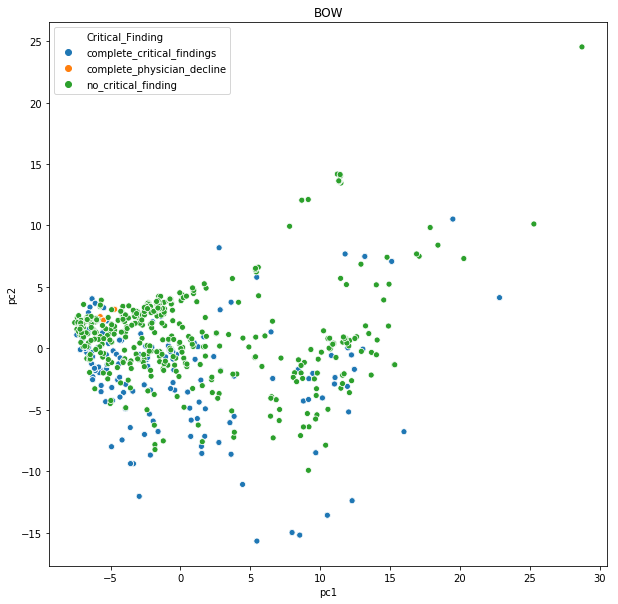

In [82]:
plt.figure(figsize = (10,10))
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_bow)
principalDf = pd.DataFrame(principalComponents, columns = ['pc1', 'pc2'])
principalDf['Critical_Finding'] = df.Critical_Finding.values
sns.scatterplot(data=principalDf, x='pc1',y='pc2',hue='Critical_Finding')
plt.title('BOW')
plt.savefig('/content/drive/My Drive/Critical_Findings/Embeddings_BOW')

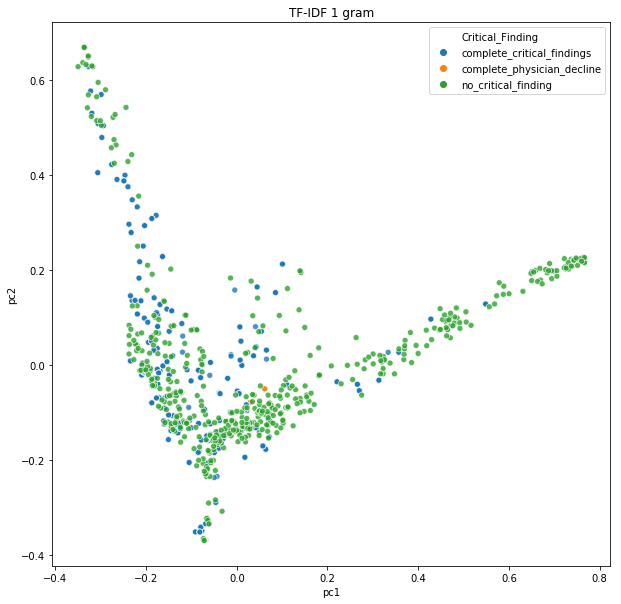

In [83]:
plt.figure(figsize = (10,10))
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_tfidf_1gram)
principalDf = pd.DataFrame(principalComponents, columns = ['pc1', 'pc2'])
principalDf['Critical_Finding'] = df.Critical_Finding.values
sns.scatterplot(data=principalDf, x='pc1',y='pc2',hue='Critical_Finding',alpha = 0.8)
plt.title('TF-IDF 1 gram')
plt.savefig('/content/drive/My Drive/Critical_Findings/Embeddings_TFIDF_1gram')

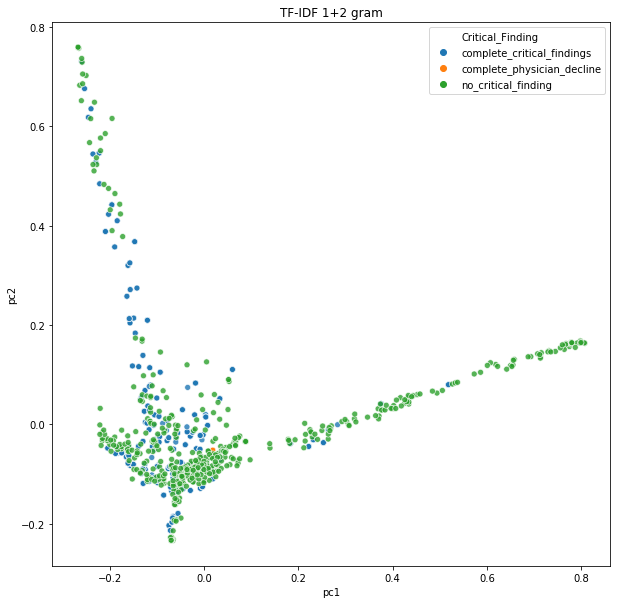

In [84]:
plt.figure(figsize = (10,10))
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_tfidf_2gram)
principalDf = pd.DataFrame(principalComponents, columns = ['pc1', 'pc2'])
principalDf['Critical_Finding'] = df.Critical_Finding.values
sns.scatterplot(data=principalDf, x='pc1',y='pc2',hue='Critical_Finding',alpha = 0.8)
plt.title('TF-IDF 1+2 gram')
plt.savefig('/content/drive/My Drive/Critical_Findings/Embeddings_TFIDF_2gram')

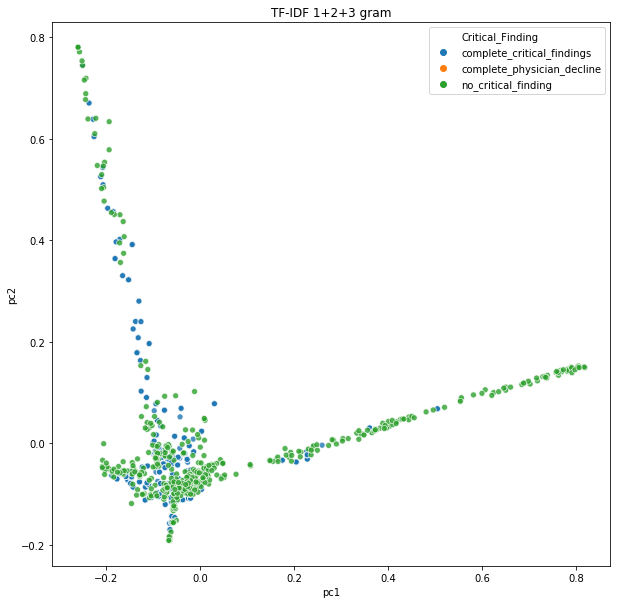

In [85]:
plt.figure(figsize = (10,10))
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_tfidf_3gram)
principalDf = pd.DataFrame(principalComponents, columns = ['pc1', 'pc2'])
principalDf['Critical_Finding'] = df.Critical_Finding.values
sns.scatterplot(data=principalDf, x='pc1',y='pc2',hue='Critical_Finding',alpha = 0.8)
plt.title('TF-IDF 1+2+3 gram')
plt.savefig('/content/drive/My Drive/Critical_Findings/Embeddings_TFIDF_3gram')

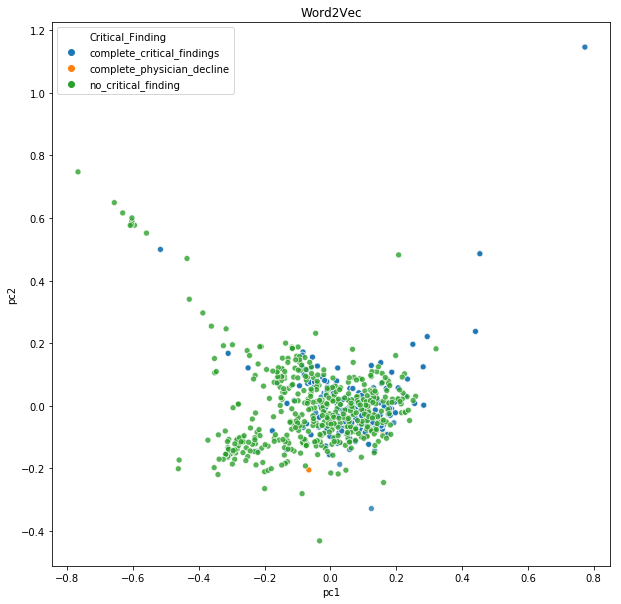

In [86]:
plt.figure(figsize = (10,10))
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_w2v)
principalDf = pd.DataFrame(principalComponents, columns = ['pc1', 'pc2'])
principalDf['Critical_Finding'] = df.Critical_Finding.values
sns.scatterplot(data=principalDf, x='pc1',y='pc2',hue='Critical_Finding',alpha = 0.8)
plt.title('Word2Vec')
plt.savefig('/content/drive/My Drive/Critical_Findings/Embeddings_Word2Vec')

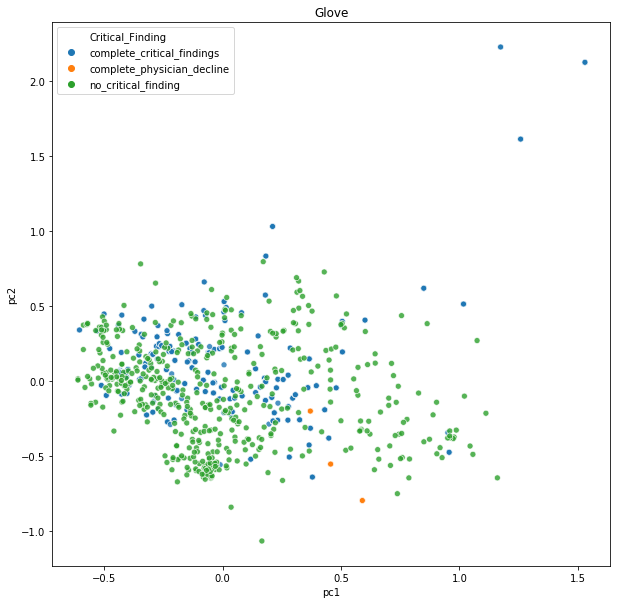

In [88]:
plt.figure(figsize = (10,10))
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df_glove)
principalDf = pd.DataFrame(principalComponents, columns = ['pc1', 'pc2'])
principalDf['Critical_Finding'] = df.Critical_Finding.values
sns.scatterplot(data=principalDf, x='pc1',y='pc2',hue='Critical_Finding',alpha = 0.8)
plt.title('Glove')
plt.savefig('/content/drive/My Drive/Critical_Findings/Embeddings_Glove')

## Data Preparation

- Train-Test data generation for the datasets from all embeddings
- Shuffled the data before splitting
- Used 70/30 randomized train-test split


In [0]:
# BOW data split

df_bow['target'] = labels.values
df_bow = df_bow.sample(frac=1).reset_index(drop=True)
df_bow_X_train, df_bow_X_test, df_bow_y_train, df_bow_y_test = train_test_split(df_bow[df_bow.columns[:-1]], df_bow['target'], test_size=0.3, random_state=27)

In [0]:
# Tfidf-1gram data split

df_tfidf_1gram['target'] = labels.values
df_tfidf_1gram = df_tfidf_1gram.sample(frac=1).reset_index(drop=True)
df_tfidf_1gram_X_train, df_tfidf_1gram_X_test, df_tfidf_1gram_y_train, df_tfidf_1gram_y_test = train_test_split(df_tfidf_1gram[df_tfidf_1gram.columns[:-1]], df_tfidf_1gram['target'], test_size=0.3, random_state=27)

In [0]:
# Tfidf-2gram data split

df_tfidf_2gram['target'] = labels.values
df_tfidf_2gram = df_tfidf_2gram.sample(frac=1).reset_index(drop=True)
df_tfidf_2gram_X_train, df_tfidf_2gram_X_test, df_tfidf_2gram_y_train, df_tfidf_2gram_y_test = train_test_split(df_tfidf_2gram[df_tfidf_2gram.columns[:-1]], df_tfidf_2gram['target'], test_size=0.3, random_state=27)

In [0]:
# Tfidf-3gram data split

df_tfidf_3gram['target'] = labels.values
df_tfidf_3gram = df_tfidf_3gram.sample(frac=1).reset_index(drop=True)
df_tfidf_3gram_X_train, df_tfidf_3gram_X_test, df_tfidf_3gram_y_train, df_tfidf_3gram_y_test = train_test_split(df_tfidf_3gram[df_tfidf_3gram.columns[:-1]], df_tfidf_3gram['target'], test_size=0.3, random_state=27)

In [0]:
# Word2Vec data split

df_w2v['target'] = labels.values
df_w2v = df_w2v.sample(frac=1).reset_index(drop=True)
df_w2v_X_train, df_w2v_X_test, df_w2v_y_train, df_w2v_y_test = train_test_split(df_w2v[df_w2v.columns[:-1]], df_w2v['target'], test_size=0.3, random_state=27)

In [0]:
# Glove data split

df_glove['target'] = labels.values
df_glove = df_glove.sample(frac=1).reset_index(drop=True)
df_glove_X_train, df_glove_X_test, df_glove_y_train, df_glove_y_test = train_test_split(df_glove[df_glove.columns[:-1]], df_glove['target'], test_size=0.3, random_state=27)

## Modeling

### Using ML Techniques

The ML models in consideration are:

1. K-Nearest Neighbours
2. SVC (linear)
3. SVC (rbf)
4. Decision Tree
5. Random Forest
6. Extra-Trees
7. Gradient Boosting
8. AdaBoost
9. XGB
10. Logistic Regression
11. MultiLayer Perceptron
12. Bagging
13. Ensemble (all above models)

- skipped CatBoost classifier as it takes longer time to converge

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier,VotingClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

In [0]:
# creating and array of vanilla ML models 

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", probability=True),
    SVC(kernel="rbf", probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier(),
    ExtraTreesClassifier(n_jobs=-1),
    LogisticRegression(),
    MLPClassifier(),
    BaggingClassifier(),
    GradientBoostingClassifier(),
    VotingClassifier(estimators=[('log_reg', LogisticRegression()), ('ada', AdaBoostClassifier()), ('extra_tree', ExtraTreesClassifier()), ('rfr', RandomForestClassifier()), ('grd_boost', GradientBoostingClassifier())], n_jobs=-1),
    ]

In [41]:
# results for ML models using BOW
for classifier in classifiers:
  classifier.fit(df_bow_X_train,df_bow_y_train)
  print(classifier.__class__.__name__,classifier.score(df_bow_X_test,df_bow_y_test))

KNeighborsClassifier 0.8833333333333333
SVC 0.9333333333333333
SVC 0.78
DecisionTreeClassifier 0.9233333333333333
RandomForestClassifier 0.9333333333333333
AdaBoostClassifier 0.8933333333333333
XGBClassifier 0.91
ExtraTreesClassifier 0.9566666666666667
LogisticRegression 0.94
MLPClassifier 0.9566666666666667
BaggingClassifier 0.9433333333333334
GradientBoostingClassifier 0.9333333333333333
VotingClassifier 0.9533333333333334


In [84]:
# results for ML models using tfidf 1gram
for classifier in classifiers:
  classifier.fit(df_tfidf_1gram_X_train,df_tfidf_1gram_y_train)
  print(classifier.__class__.__name__, classifier.score(df_tfidf_1gram_X_test,df_tfidf_1gram_y_test))

KNeighborsClassifier 0.9
SVC 0.9333333333333333
SVC 0.5166666666666667
DecisionTreeClassifier 0.8833333333333333
RandomForestClassifier 0.9133333333333333
AdaBoostClassifier 0.8733333333333333
XGBClassifier 0.9033333333333333
ExtraTreesClassifier 0.9466666666666667
LogisticRegression 0.9066666666666666
MLPClassifier 0.9266666666666666
BaggingClassifier 0.91
GradientBoostingClassifier 0.9133333333333333
VotingClassifier 0.94


In [85]:
# results for ML models using tfidf 2gram
for classifier in classifiers:
  classifier.fit(df_tfidf_2gram_X_train,df_tfidf_2gram_y_train)
  print(classifier.__class__.__name__, classifier.score(df_tfidf_2gram_X_test,df_tfidf_2gram_y_test))

KNeighborsClassifier 0.8366666666666667
SVC 0.92
SVC 0.4866666666666667
DecisionTreeClassifier 0.9033333333333333
RandomForestClassifier 0.91
AdaBoostClassifier 0.8933333333333333
XGBClassifier 0.9033333333333333
ExtraTreesClassifier 0.9366666666666666
LogisticRegression 0.9033333333333333
MLPClassifier 0.9333333333333333
BaggingClassifier 0.9233333333333333
GradientBoostingClassifier 0.9266666666666666
VotingClassifier 0.94


In [86]:
# results for ML models using tfidf 3gram
for classifier in classifiers:
  classifier.fit(df_tfidf_3gram_X_train,df_tfidf_3gram_y_train)
  print(classifier.__class__.__name__, classifier.score(df_tfidf_3gram_X_test,df_tfidf_3gram_y_test))

KNeighborsClassifier 0.8466666666666667
SVC 0.9133333333333333
SVC 0.51
DecisionTreeClassifier 0.9
RandomForestClassifier 0.92
AdaBoostClassifier 0.8933333333333333
XGBClassifier 0.9233333333333333
ExtraTreesClassifier 0.9233333333333333
LogisticRegression 0.9066666666666666
MLPClassifier 0.9566666666666667
BaggingClassifier 0.93
GradientBoostingClassifier 0.9466666666666667
VotingClassifier 0.9366666666666666


In [88]:
# results for ML models using word2vec
for classifier in classifiers:
  classifier.fit(df_w2v_X_train,df_w2v_y_train)
  print(classifier.__class__.__name__, classifier.score(df_w2v_X_test,df_w2v_y_test))

KNeighborsClassifier 0.87
SVC 0.7966666666666666
SVC 0.49666666666666665
DecisionTreeClassifier 0.87
RandomForestClassifier 0.9033333333333333
AdaBoostClassifier 0.88
XGBClassifier 0.91
ExtraTreesClassifier 0.9366666666666666
LogisticRegression 0.77
MLPClassifier 0.8833333333333333
BaggingClassifier 0.9066666666666666
GradientBoostingClassifier 0.9466666666666667
VotingClassifier 0.9366666666666666


In [89]:
# results for ML models using Glove
for classifier in classifiers:
  classifier.fit(df_glove_X_train,df_glove_y_train)
  print(classifier.__class__.__name__, classifier.score(df_glove_X_test,df_glove_y_test))

KNeighborsClassifier 0.86
SVC 0.8033333333333333
SVC 0.5066666666666667
DecisionTreeClassifier 0.86
RandomForestClassifier 0.9
AdaBoostClassifier 0.9266666666666666
XGBClassifier 0.9166666666666666
ExtraTreesClassifier 0.9633333333333334
LogisticRegression 0.8266666666666667
MLPClassifier 0.8966666666666666
BaggingClassifier 0.89
GradientBoostingClassifier 0.9166666666666666
VotingClassifier 0.9366666666666666


## Deep Learning Models

DL models in consideration
1. **Simple Conv1D** w/ one layer of 128 neurons and stride size as 5
2. **Simple LSTM** model w/ one layer of 100 LSTM cells
3. **Bi-directional LSTM** model w/ one layer of 100 LSTM cells
4. **Conv1D w/ LSTM** same layers config as that of model 1 and 2
5. **Conv1D w/ Bi-LSTM** same layers config as that of model 1 and 3


In [0]:
# install tensorflow gpu version
!pip install tensorflow-gpu

In [0]:
# import keras modules
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, GRU
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional, TimeDistributed, GlobalMaxPool1D

In [0]:
# a function to plot the train-validation loss and accuracy graph per epoch

def plot_history(history):
  #  "Accuracy"
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

In [0]:
# Manual label encoding of traget values

labels = df.Critical_Finding.replace(['complete_critical_findings', 'complete_physician_decline','no_critical_finding'], [1,1,0])

# creating a separate clean df
df_cleaned = pd.DataFrame(df['Data'])
df_cleaned['target'] = labels.values
df_cleaned['Category'] = df.Category

# shuffling and splitting the data into train-test with 70/30 split 
df_cleaned = df_cleaned.sample(frac=1).reset_index(drop=True)
df_cleaned_X_train, df_cleaned_X_test, df_cleaned_y_train, df_cleaned_y_test = train_test_split(df_cleaned[['Data']], df_cleaned['target'], test_size=0.3, random_state=27)

In [0]:
# Model templates

def create_conv_model():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=200))
    model.add(Dropout(0.2))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model

def create_lstm_model():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=200))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model
  
def create_bilstm_model():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=200))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model
  
def create_convlstm_model():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=200))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(100))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model

def create_convbilstm_model():
    model = Sequential()
    model.add(Embedding(vocabulary_size, 100, input_length=200))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(GlobalMaxPool1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model

### Keras Tokenizer
- 

In [0]:
# max vocab size allowed
vocabulary_size = 20000

# train keras tokenizer on the text data
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df_cleaned_X_train['Data'])

# convert the train text to sequences of words using the trained tokenizer
sequences = tokenizer.texts_to_sequences(df_cleaned_X_train['Data'])

# Pad the sequences with each document with max length of 200
data_train = pad_sequences(sequences, maxlen=200)

# convert the test text to sequences of words using the trained tokenizer
sequences = tokenizer.texts_to_sequences(df_cleaned_X_test['Data'])

# Pad the sequences with each document with max length of 200
data_test = pad_sequences(sequences, maxlen=200)

applyiing all dl models

In [35]:
model = create_conv_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9929
Testing Accuracy:  0.9333


In [39]:
model = create_lstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9900
Testing Accuracy:  0.9333


In [41]:
model = create_bilstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9843
Testing Accuracy:  0.9200


Training Accuracy: 0.9871
Testing Accuracy:  0.9267


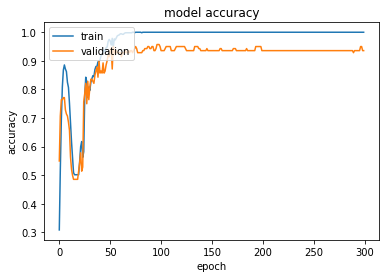

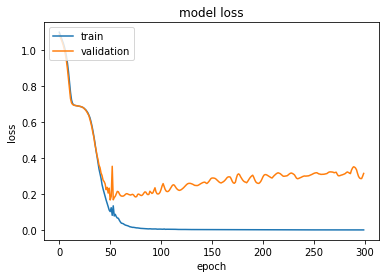

In [27]:
model = create_convlstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 300, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Training Accuracy: 0.9871
Testing Accuracy:  0.9267


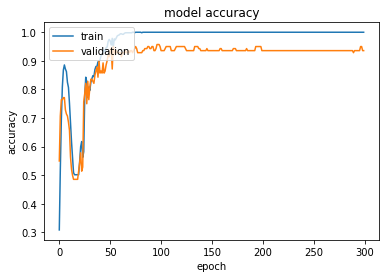

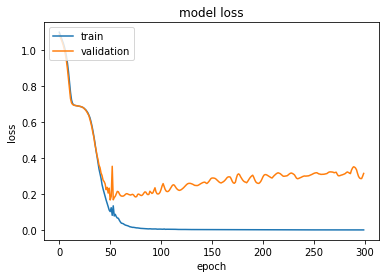

In [0]:
model = create_convbilstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 300, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### Using Word2Vec

In [0]:
# creating embedding matrix from pretrained Word2Vec embeddings
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        try:
          embedding_vector = word2vec[word]
          if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        except:
          embedding_matrix[index] = np.array([0]*300)

In [61]:
model = create_conv_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9829
Testing Accuracy:  0.8967


In [63]:
model = create_lstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9743
Testing Accuracy:  0.9200


In [65]:
model = create_bilstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9314
Testing Accuracy:  0.8667


Training Accuracy: 0.9929
Testing Accuracy:  0.9233


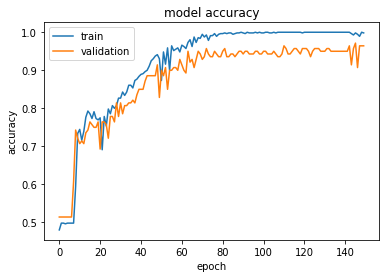

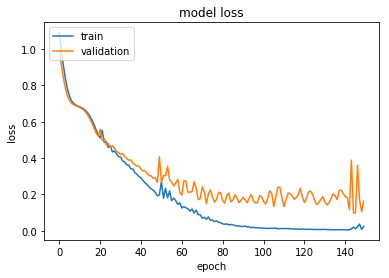

In [67]:
model = create_convlstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Training Accuracy: 0.9871
Testing Accuracy:  0.9267


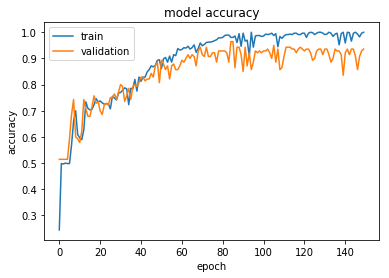

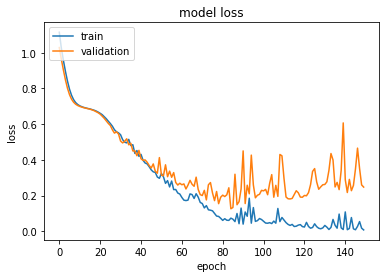

In [69]:
model = create_convbilstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

#### Extracting the data which is predicted as having critical-finding

In [0]:
df_pred_critical = df_cleaned_X_test.iloc[np.where(np.argmax(model_w2v.predict(data_test), axis=1) == 1)]
df_pred_critical.head()

,Data
23,study computed tomography abdomen pelvis contr...
47,consult completed florez june est
459,study computed tomography abdomen pelvis witho...
732,study cta chest reason exam male year old ches...
432,study computed tomography abdomen pelvis contr...


In [0]:
# getting the cleaned df only with complete-critical-findings
df_critical_cleaned = df_cleaned[df_cleaned.target == 1]

### Using Glove

In [0]:
# creating the embedding matrix using Glove pretrained embeddings for fine-tuning
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [72]:
model = create_conv_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9814
Testing Accuracy:  0.9100


In [74]:
model = create_lstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9800
Testing Accuracy:  0.9233


In [76]:
model = create_bilstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9800
Testing Accuracy:  0.8867


In [78]:
model = create_convlstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9886
Testing Accuracy:  0.9300


In [80]:
model = create_convbilstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9857
Testing Accuracy:  0.9033


### FastText

In [81]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec

--2019-08-19 13:57:25--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.simple.vec
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:16a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 293187541 (280M) [binary/octet-stream]
Saving to: ‘wiki.simple.vec’

wiki.simple.vec     100%[===================>] 279.60M  26.5MB/s    in 11s     

2019-08-19 13:57:37 (25.6 MB/s) - ‘wiki.simple.vec’ saved [293187541/293187541]



In [0]:
import gensim
fasttext = gensim.models.KeyedVectors.load_word2vec_format('wiki.simple.vec')

In [0]:
# set vocab size
vocabulary_size = 20000

# creating the embedding matrix using FastText embeddings
embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        try:
          embedding_vector = fasttext[word]
          if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        except:
          embedding_matrix[index] = np.array([0]*300)

In [85]:
model = create_conv_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9757
Testing Accuracy:  0.8667


In [87]:
model = create_lstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9843
Testing Accuracy:  0.9000


In [89]:
model = create_conv_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.9514
Testing Accuracy:  0.8733


Training Accuracy: 0.9800
Testing Accuracy:  0.9100


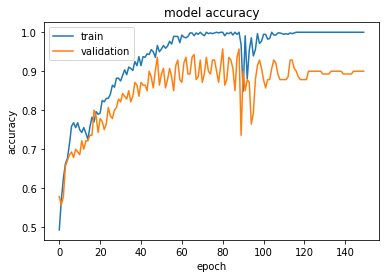

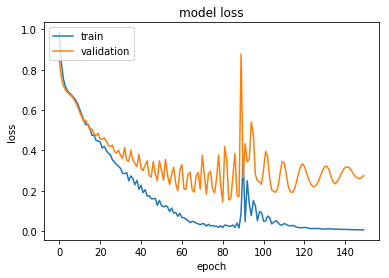

In [91]:
model = create_bilstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

Training Accuracy: 0.9771
Testing Accuracy:  0.8900


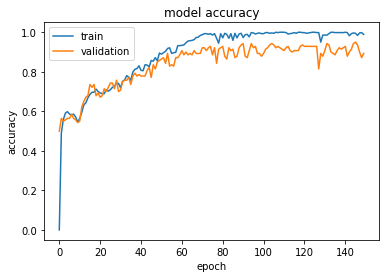

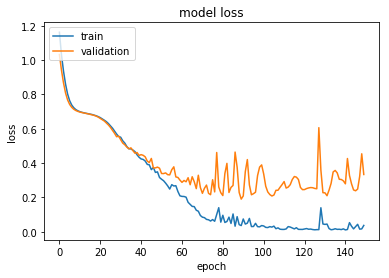

In [93]:
model = create_bilstm_model()
history = model.fit(data_train, np.array(df_cleaned_y_train), validation_split=0.2, epochs = 150, batch_size = 1000,verbose = 0)

loss, accuracy = model.evaluate(data_train, df_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(data_test, df_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Category Prediction

In [0]:
# drop the Critical-Findings column for category prediction
df_critical_cleaned.drop('target',axis=1,inplace=True)
df_critical_cleaned.head()

,Data,Category
0,exam computed tomography scan brain without co...,Other
7,study computed tomography soft tissue neck con...,Other
9,study computed tomography abdomen pelvis contr...,Unsuspected Injury
11,computed tomography upper extremity contrast i...,Significant Vascular Pathology
15,study mri cervical spine without contrast reas...,Cancer/Neoplasm


In [0]:
# Label Encode the Category column for prediction
from sklearn.preprocessing import LabelEncoder
df_critical_cleaned.Category = LabelEncoder().fit_transform(df_critical_cleaned.Category)

In [0]:
# split the data w/ 70/30 train-test split
labels = df_critical_cleaned.Category
df_critical_cleaned_X_train, df_critical_cleaned_X_test, df_critical_cleaned_y_train, df_critical_cleaned_y_test = train_test_split(df_critical_cleaned[['Data']], df_critical_cleaned['Category'], test_size=0.3, random_state=27)

In [0]:
# prepare the data using Keras tokenizer

tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(df_critical_cleaned_X_train['Data'])
sequences = tokenizer.texts_to_sequences(df_critical_cleaned_X_train['Data'])
data_critical_train = pad_sequences(sequences, maxlen=200)

sequences = tokenizer.texts_to_sequences(df_critical_cleaned_X_test['Data'])
data_critical_test = pad_sequences(sequences, maxlen=200)

In [0]:
# creating the embeddings matrix using Word2Vec embeddings

embedding_matrix = np.zeros((vocabulary_size, 300))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        try:
          embedding_vector = word2vec[word]
          if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        except:
          embedding_matrix[index] = np.array([0]*300)

In [0]:
# Word2Vec model for Category Prediction

# Conv1D w/ Bi-LSTM 
model_w2v = Sequential()
model_w2v.add(Embedding(vocabulary_size, 300, input_length=200, weights=[embedding_matrix], trainable=False))
model_w2v.add(Dropout(0.2))
model_w2v.add(Conv1D(128, 5, activation='relu'))
model_w2v.add(MaxPooling1D(pool_size=4))
model_w2v.add(Bidirectional(LSTM(50, return_sequences=True)))
model_w2v.add(GlobalMaxPool1D())
model_w2v.add(Dense(50, activation="relu"))
model_w2v.add(Dropout(0.2))
model_w2v.add(Dense(7, activation='sigmoid'))
model_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit train data
history = model_w2v.fit(data_critical_train, df_critical_cleaned_y_train.values, validation_split=0.3, epochs = 100, batch_size = 1000,verbose = 0)

Training Accuracy: 0.9708
Testing Accuracy:  0.8851


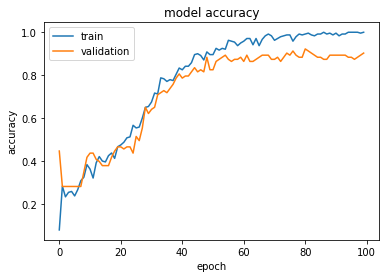

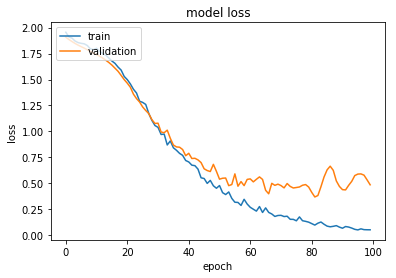

In [0]:
loss, accuracy = model_w2v.evaluate(data_critical_train, df_critical_cleaned_y_train.values, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model_w2v.evaluate(data_critical_test, df_critical_cleaned_y_test.values, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)